This notebook is used to develop functions for creating pointcloud labels from the cylinder models. Both the offset-vectors as well as the noise-labels are generated

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fastprogress import progress_bar, master_bar
import os 
import sys

# Get access to all the files in the repository
cwd = os.getcwd()
parentDir = os.path.dirname( cwd )
sys.path.append(parentDir)

First load a single cylinder and test the function for finding the closest cylinder

In [24]:
cylinders = pd.read_csv( os.path.join(parentDir, 'data', 'raw', 'QSM', 'detailed', '33_1_000000.csv'), header=0)
print(cylinders.columns)
cylinders.columns = cylinders.columns.str.strip() # Clean whitespaces
print(cylinders.columns)
cylinders.head()

Index(['type', ' ID', ' parentID', ' startX', ' startY', ' startZ', ' endX',
       ' endY', ' endZ', ' radius', ' volume', ' growthVolume', ' length',
       ' growthLength', ' FittingType', 'segmentID', ' parentSegmentID',
       ' segmentMedianRadius', ' segmentGrowthVolume', ' segmentGrowthLength',
       ' branchOrder', ' reverseBranchOrder', ' reversePipeRadiusBranchorder',
       ' reversePipeAreaBranchorder', ' branchID', ' treeID', ' treeSpecies',
       ' translateX', ' translateY', ' translatez', ' gvA', ' gvB', ' gvC',
       ' glA', ' glB', ' glC'],
      dtype='object')
Index(['type', 'ID', 'parentID', 'startX', 'startY', 'startZ', 'endX', 'endY',
       'endZ', 'radius', 'volume', 'growthVolume', 'length', 'growthLength',
       'FittingType', 'segmentID', 'parentSegmentID', 'segmentMedianRadius',
       'segmentGrowthVolume', 'segmentGrowthLength', 'branchOrder',
       'reverseBranchOrder', 'reversePipeRadiusBranchorder',
       'reversePipeAreaBranchorder', 'branchID'

,type,ID,parentID,startX,startY,startZ,endX,endY,endZ,radius,...,treeSpecies,translateX,translateY,translatez,gvA,gvB,gvC,glA,glB,glC
0,cylinder,0,-1,27.268867,23.687374,-1.574510,27.310114,23.677517,-1.342370,0.147356,...,unknownSpecies,0.0,0.0,0.0,0.01,0.401606,0.0,0.01,0.401606,0.0
1,cylinder,1,0,27.310114,23.677517,-1.342370,27.323258,23.685699,-1.127219,0.147300,...,unknownSpecies,0.0,0.0,0.0,0.01,0.401606,0.0,0.01,0.401606,0.0
2,cylinder,2,1,27.323258,23.685699,-1.127219,27.372589,23.700213,-0.947553,0.147255,...,unknownSpecies,0.0,0.0,0.0,0.01,0.401606,0.0,0.01,0.401606,0.0
3,cylinder,3,2,27.372589,23.700213,-0.947553,27.363788,23.667894,-0.756015,0.147214,...,unknownSpecies,0.0,0.0,0.0,0.01,0.401606,0.0,0.01,0.401606,0.0
4,cylinder,4,3,27.363788,23.667894,-0.756015,27.380559,23.656645,-0.605488,0.147182,...,unknownSpecies,0.0,0.0,0.0,0.01,0.401606,0.0,0.01,0.401606,0.0


For speeding up the process of finding the nearest cylinder check the length distribution of cylinders

(array([128., 173., 180., 227., 269., 229., 234., 192., 222., 257., 249.,
        220., 193., 163., 145., 106., 124.,  82.,  73.,  50.,  34.,  25.,
         23.,  25.,  15.,   9.,   4.,   5.,   7.,   4.,   1.,   2.,   2.,
          5.,   1.,   0.,   2.,   0.,   2.,   0.,   1.,   2.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.32058075,  1.18024668,  2.0399126 ,  2.89957853,  3.75924446,
         4.61891038,  5.47857631,  6.33824224,  7.19790817,  8.05757409,
         8.91724002,  9.77690595, 10.63657188, 11.4962378 , 12.35590373,
        13.21556966, 14.07523558, 14.93490151, 15.79456744, 16.65423337,
        17.51389929, 18.37356522, 19.23323115, 20.09289707, 20.952563  ,
        21.81222893, 22.67189486, 23.53156078, 24.39122671, 25.25089264,
        26.11055857, 26.97022449, 27.82989042, 28.68955635, 29.54922227,
        30.4088882 , 31.26855413, 32.12822006, 32.98788598, 33.84755191,
        34.70721784, 35.56688376, 36.42654969, 37.28621562, 38.14588155,
 

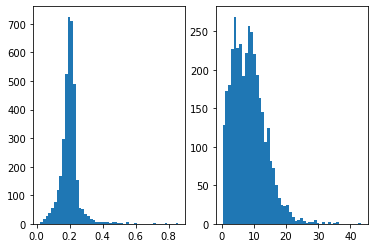

In [56]:
lengths = []
relativeLengths = []
for _, cylinder in cylinders.iterrows():
    start = np.array([cylinder['startX'], cylinder['startY'], cylinder['startZ']])
    end = np.array([cylinder['endX'], cylinder['endY'], cylinder['endZ']])
    radius = cylinder['radius']
    lengths.append( np.linalg.norm(start-end) )
    relativeLengths.append( np.linalg.norm(start-end)/radius )

fig, ax = plt.subplots(1,2)
ax[0].hist(lengths, bins=50)
ax[1].hist(relativeLengths, bins=50)

In [61]:
def closest_cylinder(point, cylinders):
    """
    Find the closest cylinder to a given point in 3D space.

    Parameters:
        point: A 3D point as a numpy array [x, y, z].
        cylinders: A list of dictionaries, where each dictionary represents a cylinder with:
                   - 'start': The start point of the cylinder axis as a numpy array [x, y, z].
                   - 'end': The end point of the cylinder axis as a numpy array [x, y, z].
                   - 'radius': The radius of the cylinder.

    Returns:
        The index of the closest cylinder and the corresponding distance.
    """
    closest_distance = float('inf')
    closest_index = -1
    closet_offset_vector = np.zeros(3)

    for _, cylinder in cylinders.iterrows():
        start = np.array([cylinder['startX'], cylinder['startY'], cylinder['startZ']])
        end = np.array([cylinder['endX'], cylinder['endY'], cylinder['endZ']])
        radius = cylinder['radius']
        id = cylinder['ID']

        if np.linalg.norm(point - start) < radius*10 or np.linalg.norm(point-end) < radius*10:

            # Cylinder axis vector
            axis = end - start
            axis_length = np.linalg.norm(axis)
            axis_unit = axis / axis_length

            # Vector from start point to the given point
            point_vector = point - start

            # Projection of point_vector onto the cylinder axis
            projection_length = np.dot(point_vector, axis_unit)
            projection_point = start + projection_length * axis_unit

            # Clamp the projection point to the cylinder segment
            projection_length_clamped = np.clip(projection_length, 0, axis_length)
            projection_point_clamped = start + projection_length_clamped * axis_unit

            # Compute the distance from the point to the clamped projection point
            distance_to_axis = np.linalg.norm(point - projection_point_clamped)

            # Subtract the cylinder radius to get the distance to the cylinder surface
            distance_to_cylinder_surface = abs(distance_to_axis - radius)

            # Update the closest cylinder
            if distance_to_cylinder_surface < closest_distance:
                closest_distance = distance_to_cylinder_surface
                closest_index = id
                closet_offset_vector = projection_point_clamped - point

    if closest_index == -1:
        print("Noise!")

    return closest_index, closest_distance, closet_offset_vector

def closest_cylinder_vectorized(point, cylinders):
    # Extract numpy arrays from the DataFrame
    start = cylinders[['startX', 'startY', 'startZ']].to_numpy()
    end = cylinders[['endX', 'endY', 'endZ']].to_numpy()
    radius = cylinders['radius'].to_numpy()
    IDs = cylinders['ID'].to_numpy()

    # Compute axis vectors and lengths
    axis = end - start
    axis_length = np.linalg.norm(axis, axis=1)
    axis_unit = axis / axis_length[:, np.newaxis]

    # Compute vectors from start to the point
    point_vector = point - start

    # Project point_vector onto the cylinder axis
    projection_length = np.sum(point_vector * axis_unit, axis=1)
    projection_point = start + projection_length[:, np.newaxis] * axis_unit

    # Clamp projection to the cylinder segment
    projection_length_clamped = np.clip(projection_length, 0, axis_length)
    projection_point_clamped = start + projection_length_clamped[:, np.newaxis] * axis_unit

    # Compute distances to the cylinder surface
    distances_to_axis = np.linalg.norm(point - projection_point_clamped, axis=1)
    distances_to_surface = np.abs(distances_to_axis - radius)

    # Find the closest cylinder
    closest_idx = np.argmin(distances_to_surface)
    return IDs[closest_idx], distances_to_surface[closest_idx], projection_point_clamped[closest_idx] - point

In [62]:
# Example usage
point = np.array([26, 23, 20])

closest_idx, closest_dist, closet_offset_vector = closest_cylinder_vectorized(point, cylinders)
print(f"The closest cylinder is at index {closest_idx} with a distance of {closest_dist} and vector {closet_offset_vector}")

The closest cylinder is at index 1111 with a distance of 0.7411319073719704 and vector [0.676347 0.217995 0.321168]


Now load an example pointcloud and perform the cylinder finding for every point

In [64]:
cloudPath = os.path.join( parentDir, "data", "raw", "cloud", "33_1.npy" )
cloud = np.load(cloudPath)

def generate_offset_cloud( cloud, cylinders, masterBar=None ):

    output_data = np.zeros((len(cloud), 7)) # point coordinates, offset vector, cylinder ID

    for i, point in progress_bar(enumerate(cloud), total=len(cloud), master=masterBar):
    # for i, point in enumerate(cloud):
        index, distance, offset_vector = closest_cylinder_vectorized( point, cylinders )

        output_data[i] = np.concatenate( (point, offset_vector, [index]) )

    return output_data


In [65]:
labeled_cloud = generate_offset_cloud( cloud, cylinders )
print(labeled_cloud[:10,:])

KeyboardInterrupt: 

(1111, 0.7411319073719704, array([0.676347, 0.217995, 0.321168]))